# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from scipy                import stats                as ss

## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_trip_2010_raw = pd.read_csv('data/2010_tripdata.csv', low_memory=False)
df_trip_2011_raw = pd.read_csv('data/2011_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_2010_raw, df_trip_2011_raw] )

df_trip_2012Q1_raw = pd.read_csv('data/2012Q1_tripdata.csv', low_memory=False)
df_trip_2012Q2_raw = pd.read_csv('data/2012Q2_tripdata.csv', low_memory=False)
df_trip_2012Q3_raw = pd.read_csv('data/2012Q3_tripdata.csv', low_memory=False)
df_trip_2012Q4_raw = pd.read_csv('data/2012Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2012Q1_raw, df_trip_2012Q2_raw, df_trip_2012Q3_raw, df_trip_2012Q4_raw] )

df_trip_2013Q1_raw = pd.read_csv('data/2013Q1_tripdata.csv', low_memory=False)
df_trip_2013Q2_raw = pd.read_csv('data/2013Q2_tripdata.csv', low_memory=False)
df_trip_2013Q3_raw = pd.read_csv('data/2013Q3_tripdata.csv', low_memory=False)
df_trip_2013Q4_raw = pd.read_csv('data/2013Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2013Q1_raw, df_trip_2013Q2_raw, df_trip_2013Q3_raw, df_trip_2013Q4_raw] )

df_trip_2014Q1_raw = pd.read_csv('data/2014Q1_tripdata.csv', low_memory=False)
df_trip_2014Q2_raw = pd.read_csv('data/2014Q2_tripdata.csv', low_memory=False)
df_trip_2014Q3_raw = pd.read_csv('data/2014Q3_tripdata.csv', low_memory=False)
df_trip_2014Q4_raw = pd.read_csv('data/2014Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2014Q1_raw, df_trip_2014Q2_raw, df_trip_2014Q3_raw, df_trip_2014Q4_raw] )

df_trip_2015Q1_raw = pd.read_csv('data/2015Q1_tripdata.csv', low_memory=False)
df_trip_2015Q2_raw = pd.read_csv('data/2015Q2_tripdata.csv', low_memory=False)
df_trip_2015Q3_raw = pd.read_csv('data/2015Q3_tripdata.csv', low_memory=False)
df_trip_2015Q4_raw = pd.read_csv('data/2015Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2015Q1_raw, df_trip_2015Q2_raw, df_trip_2015Q3_raw, df_trip_2015Q4_raw] )

df_trip_2016Q1_raw = pd.read_csv('data/2016Q1_tripdata.csv', low_memory=False)
df_trip_2016Q2_raw = pd.read_csv('data/2016Q2_tripdata.csv', low_memory=False)
df_trip_2016Q3_raw = pd.read_csv('data/2016Q3_tripdata.csv', low_memory=False)
df_trip_2016Q4_raw = pd.read_csv('data/2016Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2016Q1_raw, df_trip_2016Q2_raw, df_trip_2016Q3_raw, df_trip_2016Q4_raw] )

df_trip_2017Q1_raw = pd.read_csv('data/2017Q1_tripdata.csv', low_memory=False)
df_trip_2017Q2_raw = pd.read_csv('data/2017Q2_tripdata.csv', low_memory=False)
df_trip_2017Q3_raw = pd.read_csv('data/2017Q3_tripdata.csv', low_memory=False)
df_trip_2017Q4_raw = pd.read_csv('data/2017Q4_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_trip_2017Q1_raw, df_trip_2017Q2_raw, df_trip_2017Q3_raw, df_trip_2017Q4_raw] )


In [5]:
df_trip_raw.sample(5)

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
356606,552,2016-07-31 09:17:03,2016-07-31 09:26:16,31110,20th St & Florida Ave NW,31260,23rd & E St NW,W22588,Member
1057869,7476,2011-11-05 16:00:25,2011-11-05 18:05:01,31221,18th & M St NW,31015,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,W00088,Casual
933764,322,2015-09-19 15:26:18,2015-09-19 15:31:41,31049,Utah St & 11th St N,31035,N Quincy St & Glebe Rd,W20692,Member
309053,824,2011-05-17 15:43:20,2011-05-17 15:57:04,31228,8th & H St NW,31217,USDA / 12th & Independence Ave SW,W00768,Casual
916531,1105,2016-06-29 07:43:36,2016-06-29 08:02:02,31243,4th & C St SW,31242,18th St & Pennsylvania Ave NW,W21514,Member


# 1.0 - DESCRIPTION OF DATA

In [6]:
df1 = df_trip_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns
# I like to modify the column names in order to change all of them in lower case and underline between words. At the same time, names must be self-explanatory.

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')

In [8]:
cols_old = ['Duration', 'Start date', 'End date', 'Start station number', 'Start station', 'End station number', 'End station', 'Bike number', 'Member type']
cols_old_ajusted = ['Duration', 'StartDate', 'EndDate', 'StartStationNumber', 'StartStation', 'EndStationNumber', 'EndStation', 'BikeNumber', 'MemberType']

# Whats is snakecase?
# Whats do inflection.underscore function?
snakecase = lambda x: inflection.underscore( x )

# Why I use lis?
cols_new = list( map( snakecase, cols_old_ajusted ) )

# rename
df1.columns = cols_new

In [9]:
# I will add the "index" column to help me in dealing with some techniques of managing data like check unbalanced data.
df1['id'] = str(df1.index)

In [10]:
df1.columns

Index(['duration', 'start_date', 'end_date', 'start_station_number',
       'start_station', 'end_station_number', 'end_station', 'bike_number',
       'member_type', 'id'],
      dtype='object')

## 1.2 Data Dimensions

In [11]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 19117643
Number of Cols: 10


## 1.3 Data Types

In [12]:
df1.dtypes
# Observe date. It has a different data type.

duration                 int64
start_date              object
end_date                object
start_station_number     int64
start_station           object
end_station_number       int64
end_station             object
bike_number             object
member_type             object
id                      object
dtype: object

In [13]:
df1['start_date'] = pd.to_datetime( df1['start_date'] )
df1['end_date'] = pd.to_datetime( df1['end_date'] )

In [14]:
df1.dtypes

duration                         int64
start_date              datetime64[ns]
end_date                datetime64[ns]
start_station_number             int64
start_station                   object
end_station_number               int64
end_station                     object
bike_number                     object
member_type                     object
id                              object
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()

duration                0
start_date              0
end_date                0
start_station_number    0
start_station           0
end_station_number      0
end_station             0
bike_number             0
member_type             0
id                      0
dtype: int64

## 1.5 Fillout NA

In [16]:
# There aren't NaN values to fill.

## 1.6 Check Unbalanced Data

In [17]:
df_balanced = df1[['id', 'member_type']].groupby( 'member_type' ).count().sort_values( 'id' ).reset_index()
df_balanced['perc%'] = 100*np.round( ( df_balanced['id'] / np.sum( df_balanced['id'] ) ), 4 )
df_balanced

,member_type,id,perc%
0,Unknown,58,0.00
1,Casual,4175473,21.84
2,Member,14942112,78.16


## 1.7 Descriptive Analysis

### 1.7.1 General

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

#### 1.7.1.1 Numerical

In [19]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,duration,60.0,86394.0,86334.0,1093.937030,673.0,2065.993636,16.465111,465.550138
1,start_station_number,31000.0,32225.0,1225.0,31303.112882,31241.0,205.059037,1.052848,0.744066
2,end_station_number,31000.0,32225.0,1225.0,31304.167477,31241.0,202.846500,1.057702,0.730085


#### 1.7.1.2 Categorical

In [20]:
cat_attributes.drop( 'id', axis=1 ).describe()

,start_station,end_station,bike_number,member_type
count,19117643,19117643,19117643,19117643
unique,488,488,4844,3
top,Columbus Circle / Union Station,Massachusetts Ave & Dupont Circle NW,W00097,Member
freq,412433,439746,8358,14942112


### 1.7.2 Classes Oriented

#### 1.7.2.1 Numerical

In [21]:
aux = df1[['duration', 'start_station_number', 'end_station_number', 'member_type']].groupby( 'member_type' ).agg( 
        duration_min      = ('duration', 'min'), 
        duration_max      = ('duration', 'max'),
        duration_mean     = ('duration', 'mean'),
        duration_median   = ('duration', 'median'),
        duration_range    = ('duration', lambda x: x.max() - x.min() ),
        duration_skew     = ('duration', lambda x: x.skew() ),
        duration_kurtosis = ( 'duration', lambda x: x.kurtosis() ),
        start_station_number_min    =   ('start_station_number', 'min'), 
        start_station_number_max    =   ('start_station_number', 'max'),
        start_station_number_mean   =   ('start_station_number', 'mean'),
        start_station_number_median =   ('start_station_number', 'median'),
        start_station_number_range  =   ('start_station_number', lambda x: x.max() - x.min() ),
        start_station_number_skew   =   ('start_station_number', lambda x: x.skew() ),
        start_station_number_kurtosis = ( 'start_station_number', lambda x: x.kurtosis() ),
        end_station_numberr_min    =   ('end_station_number', 'min'), 
        end_station_number_max    =   ('end_station_number', 'max'),
        end_station_number_mean   =   ('end_station_number', 'mean'),
        end_station_number_median =   ('end_station_number', 'median'),
        end_station_number_range  =   ('end_station_number', lambda x: x.max() - x.min() ),
        end_station_number_skew   =   ('end_station_number', lambda x: x.skew() ),
        end_station_number_kurtosis = ( 'end_station_number', lambda x: x.kurtosis() ) )

# show table
aux

,duration_min,duration_max,duration_mean,duration_median,duration_range,duration_skew,duration_kurtosis,start_station_number_min,start_station_number_max,start_station_number_mean,start_station_number_median,start_station_number_range,start_station_number_skew,start_station_number_kurtosis,end_station_numberr_min,end_station_number_max,end_station_number_mean,end_station_number_median,end_station_number_range,end_station_number_skew,end_station_number_kurtosis
member_type,,,,,,,,,,,,,,,,,,,,,
Casual,60,86394,2422.380496,1454,86334,9.515771,161.433538,31000,32225,31278.031715,31247.0,1225,1.847427,4.699419,31000,32225,31277.975376,31247,1225,1.816883,4.533436
Member,60,86381,722.713754,568,86321,35.275772,1742.299807,31000,32225,31310.121842,31239.0,1225,0.900120,0.207868,31000,32225,31311.486860,31239,1225,0.909848,0.215187
Unknown,125,2477,748.172414,553,2352,1.519746,2.208551,31007,31623,31252.517241,31229.5,616,1.159526,1.226191,31002,31632,31258.689655,31221,630,0.954032,0.138627


#### 1.7.2.2 Categorical

In [22]:
cat_attributes.drop( 'id', axis=1 ).groupby( 'member_type' ).describe()

start_station                                                   end_station                                                     bike_number                     
                    count unique                                top    freq       count unique                                  top    freq       count unique     top  freq
member_type                                                                                                                                                                 
Casual            4175473    488                   Lincoln Memorial  244118     4175473    488                     Lincoln Memorial  239676     4175473   4838  W00195  1803
Member           14942112    488    Columbus Circle / Union Station  363247    14942112    488      Columbus Circle / Union Station  364978    14942112   4843  W00097  6565
Unknown                58     40  USDA / 12th & Independence Ave SW       4          58     45  Crystal City Metro / 18th & Bell St       3          58     57  W00456     2

### 1.7.3 Predictors and Class Correlation

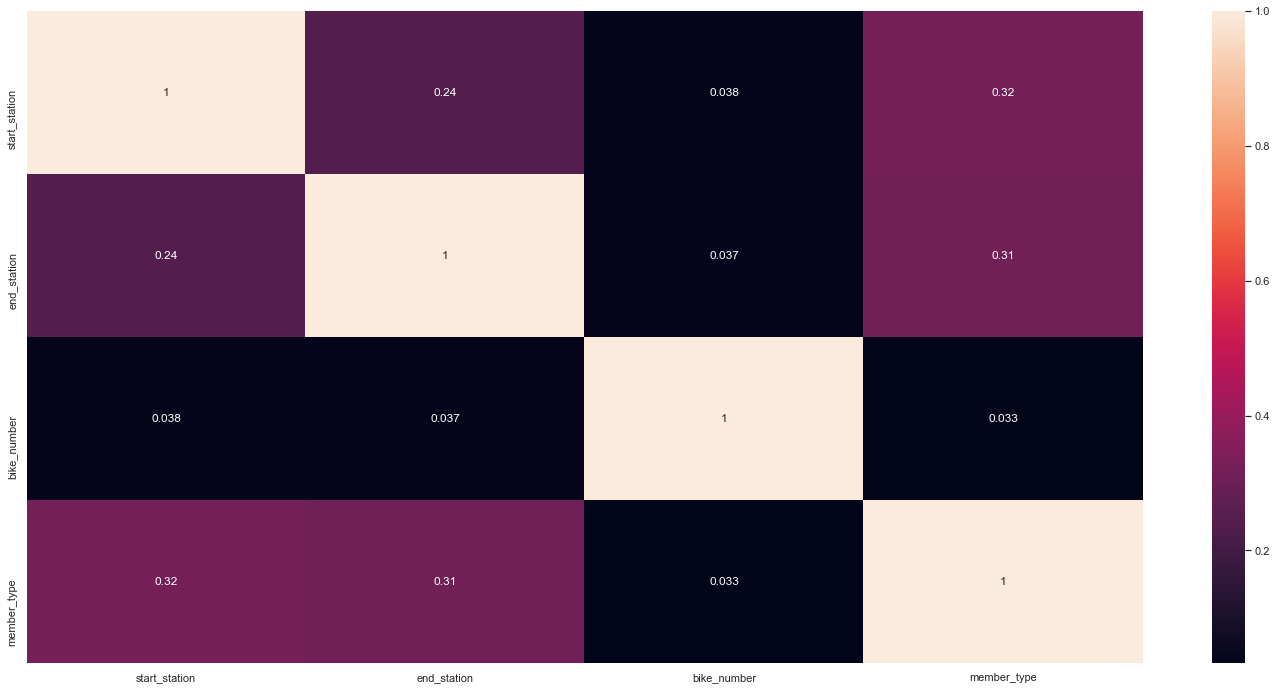

In [23]:
# list of categorical attributes
cat_attributes_list = cat_attributes.drop( 'id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 2.0 FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

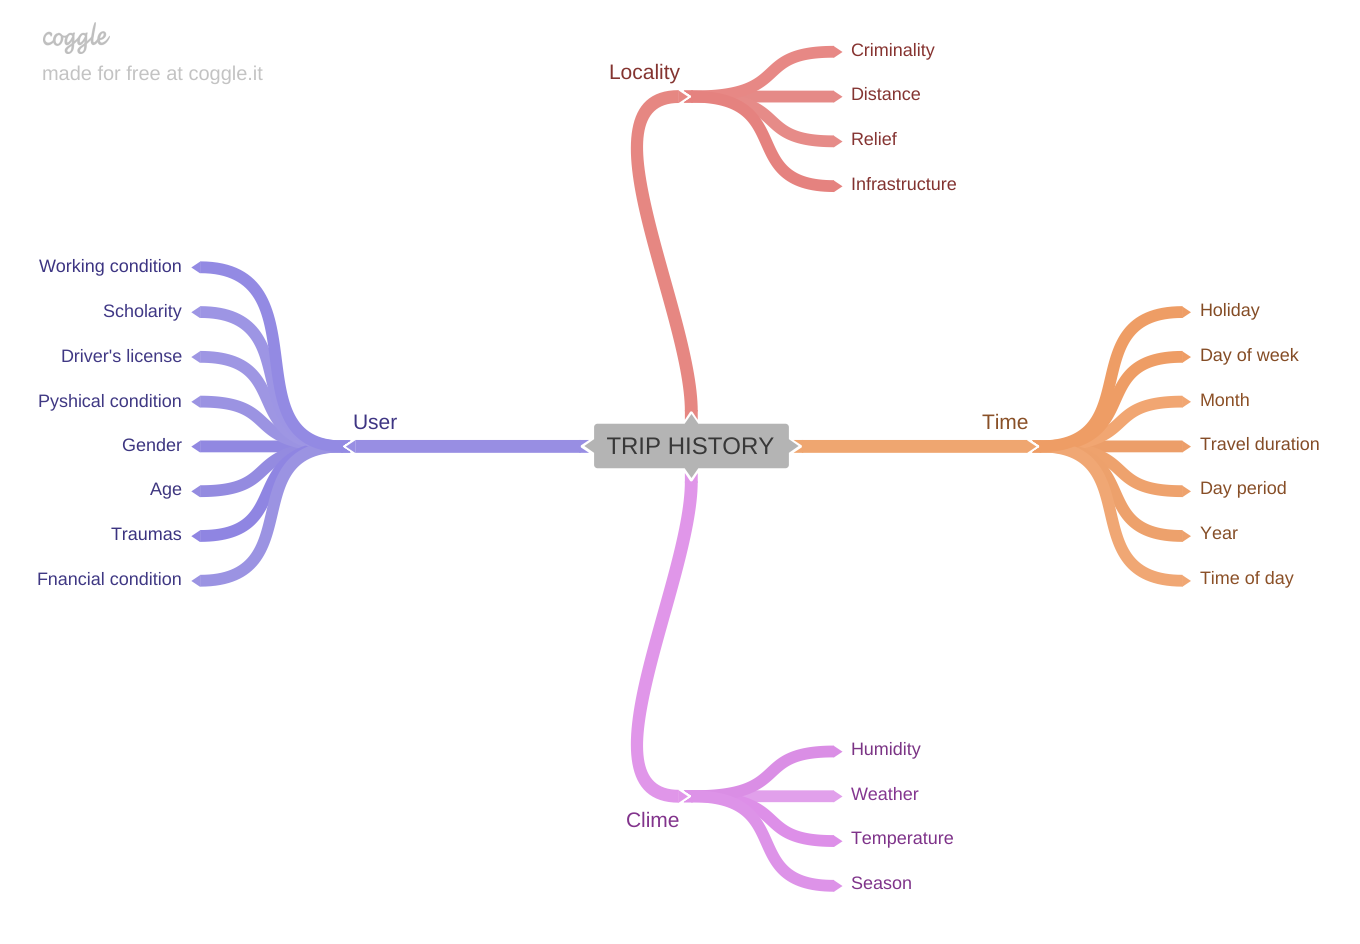

In [25]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hypotheses

### 2.1.1 Locality Hyphoteses

**1.** Casual users should be in places with higher crime.

**2.** Member users must travel greater distances.

**3.** Casual users should use the bike in steep reliefs.

**4.** Casual users should be present in greater numbers in places with more infrastructure.

### 2.1.2 Time Hyphoteses

**1.** Casual users should use more on holidays.

**2.** Member users should use more on weekdays.

**3.** Member users should use it consistently over the months.

**4.** Casual users should have longer travel times.

**5.** Member users should use more during daylight hours.

**6.** The use of casual users must have increased over the years.

**7.** Member users should use more in the early hours of the day and in the late afternoon. 

### 2.1.3 Clime Hyphoteses

**1.** Member users should use more with high humidity.

**2.** Casual users should use less during rainy seasons.

**3.** Member users should use more with high temperature.

**4.** Casual users should use more in the summer seasons.

### 2.1.4 User Hyphoteses

**1.** Member users must use more to work.

**2.** Member users should be more present in high school students.

**3.** Casual users should mostly have a driver's license.

**4.** Member users should be in better physical condition.

**5.** Casual users should be mostly men.

**6.** Member users must be mostly young.

**7.** Member users must not have trauma.

**8.** Member users must not have a good financial condition.

In [ ]:
## 2.2 Create New Features